In [ ]:
# @title Install required libraries (try-catch safe)
"""
NOTE: You can save the Docker image state after running this block so that you don't have to run it every time you start a new environment.
"""
import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# ipywidgets
try:
    import ipywidgets
except ImportError:
    !pip install ipywidgets

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# vtk
try:
    import vtk
except ImportError:
    !pip install vtk

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

# meshio
try:
    import meshio
except ImportError:
    !pip install meshio

# pyvista
try:
    import pyvista
except ImportError:
    !pip install pyvista

--2024-11-12 16:48:12--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4164 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.07K  --.-KB/s    in 0s      

2024-11-12 16:48:12 (31.6 MB/s) - ‘/tmp/fenics-install.sh’ saved [4164/4164]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/7b6613c7/releases/pybind11-ins

In [ ]:
# @title Import required modules
import os
WD_PATH = "" # If you're using the default Colab runtime, this is just where the runtime is located
# DATA_FILE_PATH = os.path.join(WD_PATH, "sortedDomain.vtk")

# Libraries
import copy
import datetime
import importlib
import json
import matplotlib.pyplot as plt
import meshio
import networkx as nx
import numpy as np
import scipy
import vtk

from dolfin import *
from graphnics import *
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
from vtk.util.numpy_support import vtk_to_numpy
from xii import *

/usr/local/lib/python3.10/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 243)

AttributeError: 'numpy.ndarray' object has no attribute 'array'

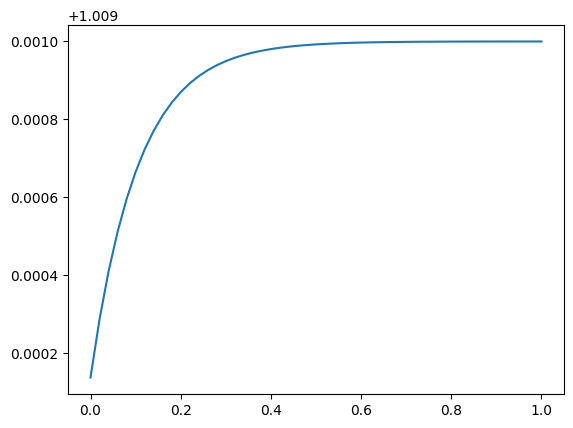

In [ ]:
# Mesh

mesh = UnitIntervalMesh(50)

# Function spaces

V_dg = FunctionSpace(mesh,"DG",1)
#V_cg = FunctionSpace(mesh,"CG",1)
#V_u  = VectorFunctionSpace(mesh,"CG",1)

# Veclocity: set as constant for now
u_constant = Constant(1.0)
u = u_constant
display(u)
#u = interpolate(u_constant,V_u)

cn = Constant(1.0)
cinlet = Constant(1.0)

# Trial and test functions
c1 = TrialFunction(V_dg)
#c3 = TrialFunction(V_dg)
w  = TestFunction(V_dg)

# Diffusion coefficient
gamma = Constant(1.0)

# Time step
dt = Constant(0.01)

# Source term
c = cn/dt
g = Constant(1.0) # c1-c3

# Penalty term
alpha = Constant(1.0)

# Mesh-related functions
n = FacetNormal(mesh)
h = CellDiameter(mesh)
#h_avg = (h('+') + h('-'))/2


# Upwind
uv = as_vector((u,))
un = (dot(uv,n) + abs(dot(uv,n)) )/2.0

# Define boundary subdomains
class Left(SubDomain):
  def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0)

class Right(SubDomain):
  def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 1)

left = Left()
right = Right()


# Mark boundaries
boundaries = MeshFunction('size_t', mesh,mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries,0)
right.mark(boundaries,1)

dxLambda = Measure('dx', domain = mesh)
dsLambda = Measure('ds', domain = mesh, subdomain_data = boundaries)

# Bilinear form

a_vol = dot(w,c1/dt)*dxLambda + dot(grad(w),grad(c1)-uv*c1)*dxLambda


a_fac = - dot(avg(grad(w)), jump(c1, n))*dS \
            - dot(jump(w, n), avg(grad(c1)))*dS \
            + (alpha('+')/h('+'))*dot(jump(w, n), jump(c1, n))*dS \
            + gamma('+')*dot(grad(w('+')),grad(c1('+')))*dS


a_vel = dot(jump(w), un('+')*c1('+') - un('-')*c1('-'))*dS \
            +dot(w,un*c1)*dsLambda(1)

a     = a_vol + a_fac + a_vel

# Linear form

L = dot(w,c)*dxLambda + u*cinlet*w*dsLambda(0) + dot(g,w)*dxLambda

# Solution function

ch = Function(V_dg)

# Define boundaries for solver

#bc = [[dxLambda], [dsLambda]]
#A, b = map(ii_assemble, (a, L))
#A, b = apply_bc(A, b, bc)
#A, b = map(ii_convert, (A, b))

#A = assemble(a)
#b = assemble(L)
#bc = dsLambda
#bc.apply(a, L)



#solve(a == L, ch, bc, solver_parameters={"linear_solver": "mumps"})
#solver = LUSolver(a==L, "mumps")
solve(a==L, ch)

plot(ch)

v = interpolate(Expression("x[0]", degree = 1), V_dg)

#print("Values on left = ", v.vector()[ch.vector() == 1].array())

#print("Values on right   = ", v.vector()[ch.vector() == 2].array())
